# 基于像素的识别

In [2]:
import pickle
import cv2
import numpy as np
from utils import split_xy

In [1]:
# 一些参数
blk_sz = 1
sensitivity = 1
selected_bands = [127, 201, 202, 294]
tree_num = 1
train_size = 140000
file_name, labeled_image_file = r"/Volumes/zc/zhouchao/616/calibrated1.raw", \
r"/Volumes/zc/zhouchao/616/label1.bmp"

test_dir = "/Volumes/zc/zhouchao/618(2)/kazhi/"

dataset_file = f'./dataset/data_{blk_sz}x{blk_sz}_c{len(selected_bands)}_sen{sensitivity}_1.p'
model_file = f'./models/rf_{blk_sz}x{blk_sz}_c{len(selected_bands)}_{tree_num}_sen{sensitivity}_4.model'

## 数据集的构建

In [6]:
with open(file_name, "rb") as f:
    data = np.frombuffer(f.read(), dtype=np.float32).reshape((600, 448, 1024)).transpose(0, 2, 1)
data = data[..., selected_bands]
label = cv2.imread(labeled_image_file)
color_dict = {(0, 0, 255): 1, (255, 255, 255): 0, (0, 255, 0): 2, (255, 0, 0): 1, (0, 255, 255): 4,
              (255, 255, 0): 5, (255, 0, 255): 6}
x, y = split_xy(data, label, blk_sz, sensitivity=sensitivity, color_dict=color_dict)
with open(dataset_file, 'wb') as f:
    pickle.dump((x, y), f)

## 数据平衡化

数据量：  614400
x train (430080, 1, 1, 4), y train (430080,)
x test (184320, 1, 1, 4), y test (184320,)
train (array([589552.,  17534.,   1208.,      0.,   1362.,   3112.,   1632.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 



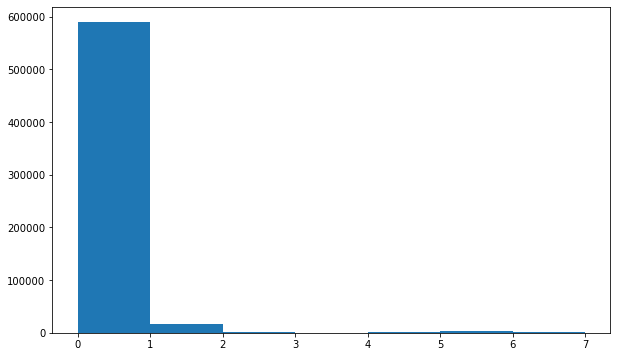

train (array([412687., 412687., 412687.,      0., 412687., 412687., 412687.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 



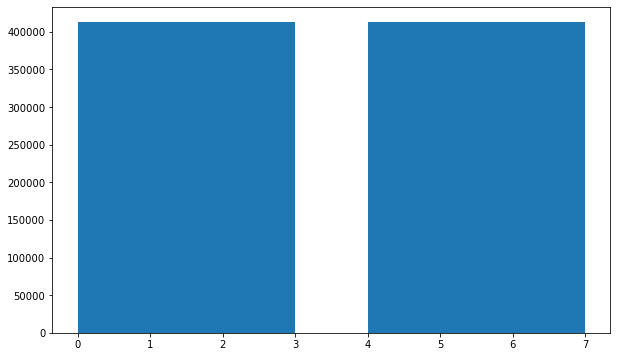

train (array([23333., 23333., 23334.,     0., 23333., 23333., 23334.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 



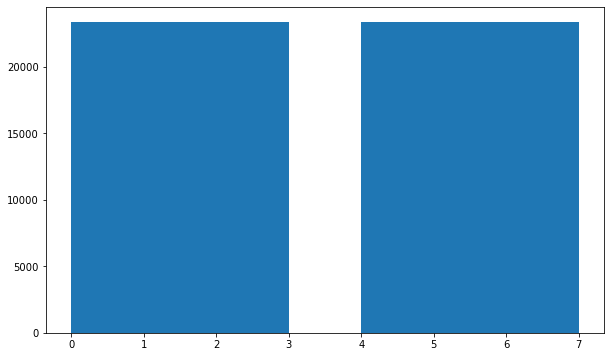

140000


In [3]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from models import train_rf_and_report
from imblearn.over_sampling import RandomOverSampler

# 读取数据
with open(dataset_file, 'rb') as f:
    x_list, y_list = pickle.load(f)
# 确保数据当中x和y数量对得上
assert len(x_list) == len(y_list)
print("数据量： ", len(x_list))
x, y = np.asarray(x_list), np.asarray(y_list, dtype=int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5,
                                                    shuffle=True, stratify=y)
print(f"x train {x_train.shape}, y train {y_train.shape}\n"
      f"x test {x_test.shape}, y test {y_test.shape}")
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y, [0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'train {hist_res_train} \n')
plt.show()

ros = RandomOverSampler(random_state=0)
x_train_shape = x_train.shape
x_train = x_train.reshape((x_train.shape[0], -1))
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_resampled, [0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
# 抽样
x_train, _, y_train, _ =  train_test_split(x_resampled, y_resampled, train_size=train_size, random_state=0, shuffle=True, stratify=y_resampled)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_train, [0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
x_train = x_train.reshape(x_train.shape[0], x_train_shape[1], x_train_shape[2], x_train_shape[3])
print(len(x_train))

## 模型训练

In [6]:
from models import feature
from models import train_t_and_report

features_train = feature(x_train)
features_test = feature(x_test)
feature_x = feature(x)
clf = train_t_and_report(features_train, y_train, feature_x, y, save_path=model_file)

预测时间： 0.032733917236328125
训练集acc：1.0
测试集acc：0.9790999348958334
--------------------------------------------------
测试集报告
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    589552
           1       0.72      0.96      0.82     17534
           2       0.66      0.89      0.76      1208
           4       0.71      0.86      0.77      1362
           5       0.48      0.87      0.62      3112
           6       0.43      0.90      0.58      1632

    accuracy                           0.98    614400
   macro avg       0.66      0.91      0.76    614400
weighted avg       0.99      0.98      0.98    614400

混淆矩阵：
[[578285   6281    383    204   2593   1806]
 [   166  16849     69    187    233     30]
 [     8     36   1075     47     37      5]
 [     4    104     52   1166     34      2]
 [    56    147     48     43   2716    102]
 [    31     21      8      1    103   1468]]
二分类报告：
              precision    recall  f1-score   suppor

## 模型评估

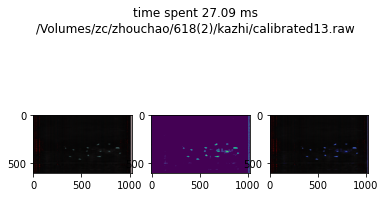

In [2]:
from models import PixelWisedDetector
from utils import visualization_evaluation

clf = PixelWisedDetector(model_path=model_file, channel_num=len(selected_bands))
visualization_evaluation(detector=clf, data_path=test_dir, selected_bands=selected_bands)